# <span style="color:darkblue"> Laboratorio di Simulazione Numerica </span>
#### <span style="color:darkred">  Andrea Sala - Settembre 2020</span>
# <span style="color:darkgreen">  Esercitazione 8</span>

## Esercizi 8.1 - 8.2

Write a C++ Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample a trial wave function $|\Psi_T(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. Using data blocking, the code should be able to compute the expectation value for the Hamiltonian $\langle {\hat H} \rangle_T $ which can be used to find the parameters that minimize this quantity. <br/> Use your Variational Monte Carlo code to find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$:

$$
\langle {\hat H} \rangle_T = \frac{\langle \Psi_T^{\sigma,\mu}| {\hat H} | \Psi_T^{\sigma,\mu} \rangle}
{\langle \Psi_T^{\sigma,\mu} | \Psi_T^{\sigma,\mu} \rangle} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

- As usual, <span style="color:red">show a picture of the estimation of $\langle {\hat H} \rangle_T$ </span> and its statistical uncertainty as a function of the number of blocks/MC steps for the set of parameters which minimize $\langle {\hat H} \rangle_T$
- <span style="color:red">show also a picture **of the sampled** $|\Psi_T(x)|^2$</span> by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below).

Il codice degli esercizi 8.1 e 8.2 è interamente scritto da me e simula un sistema monodimensionale di una particella quantistica soggetta al potenziale $V(x) = x^4 - \frac{5}{2}x^2$. Per campionare la sua funzione d'onda viene usato il già noto Algoritmo di Metropolis (vedi esercitazioni precedenti). Oltre alla funzione d'onda, però, il codice è anche in grado di calcolare l'energia del sistema, intesa come valor medio dell'hamiltoniana $H = -\frac{\hbar^2}{2m}\frac{d^2}{dx^2}+V(x)$. Il lavoro preliminare è stato infatti quello di scegliere un passo $\delta$ adeguato in modo da aver un rate di accettazione del Metropolis vicino al 50%, ed è stato scelto il valore $\delta=5.3$. 

Il codice utilizza un metodo Monte Carlo Variazionale (VMC), ovvero cerca di ricavare l'energia di ground state del sistema calcolando il valor medio dell'energia su funzioni di prova del tipo $$\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$$
La prima parte del lavoro è stata infatti la ricerca della migliore coppia di parametri $(\mu, \sigma)$ in grado di minimizzare l'energia, ovvero quelli che avvicinano il valor medio di $H$ all'autovalore di ground state. Per farlo ho costrutito una sezione di codice attivabile da un file di input (con la variabile `BestParams`) che campiona la funzione d'onda con diversi valori dei parametri. Capisco che questo è un metodo *brute force* ma almeno così sono sicuro di non finire in minimi locali e di non fare approssimazioni (cosa che potrebbe invece succedere praticando un simulated annealing). Di seguito si può osservare la distribuzioni dei candidati di minima energia in funzione dei due parametri. Una volta identificato il minimo, si sono inseriti questi due parametri $\mu_{best}$ e $\sigma_{best}$ nella seconda parte del codice che campiona la funzione d'onda e l'hamiltoniana, facendo uso delle solite tecniche di *data blocking*. <br/>

Per rappresentare la funzione d'onda si è scelto di riempire un istogramma dividendo in 1000 bin l'intervallo $[-5,5]$ e aggiungendo un'unità alla frequenza del bin quando il Metropolis campionava un punto all'interno di quell'intervallo (ovviamente quando una mossa veniva rifiutata si aggiungeva nuovamente un'unità al bin precedente). L'istogramma realizzato è stato sovrapposto a due curve: quella analitica in cui sono stati inseriti i valori ottimali dei parametri, e l'altra proveniente dalla risoluzione dell'equazione di Schrödinger in forma matriciale.

In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import math
import scipy
from mpl_toolkits.mplot3d import Axes3D
import subprocess
import os

%config InlineBackend.figure_format = 'retina'

In [2]:
def Vpot(x):
    return (x**2 - 2.5)*x**2

def Psi(x, mu, sigma):
    return np.exp(-(x-mu)*(x-mu)/(2.*sigma*sigma))+np.exp(-(x+mu)*(x+mu)/(2.*sigma*sigma))

def Psi_Sq(x, mu, sigma):
    return Psi(x, mu, sigma)*Psi(x, mu, sigma)

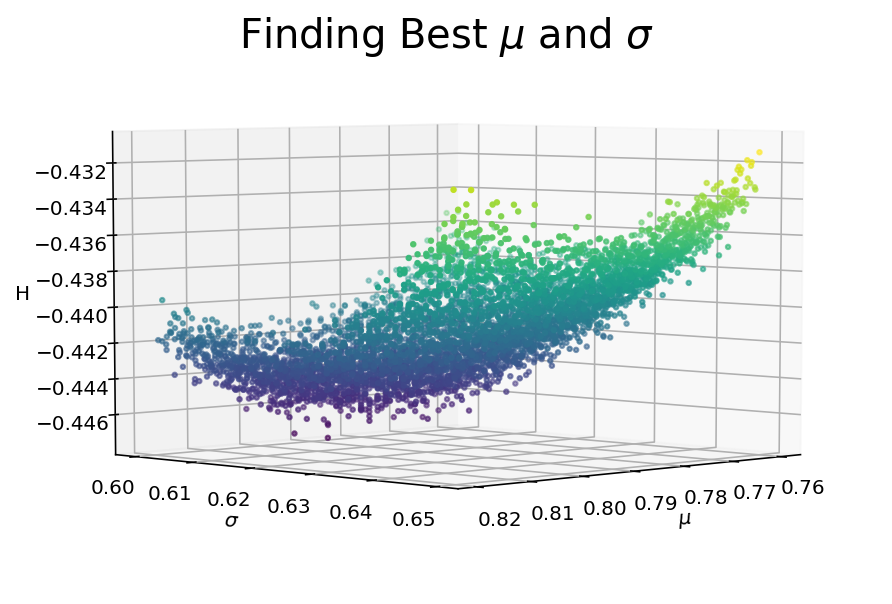

In [3]:
mu, sig, En = np.loadtxt("VMC/LastH.out", usecols=(0,1,2), unpack=True)
fig = plt.figure(figsize=(6,4))

ax = Axes3D(fig)
ax.set_title("Finding Best $\mu$ and $\sigma$", fontsize=20)
ax.scatter(mu, sig, En, c=En, marker='.')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('H')
ax.view_init(5,45)

plt.show()

min_index=np.argmin(En)
s_index=(min_index%sig.size) #indice di sigmabest


In [4]:
print("mu_best: " , mu[min_index] )
print("sigma_best: " , sig[s_index] )

mu_best:  0.8064
sigma_best:  0.6175


In [5]:
block, Ham, err_H = np.loadtxt("VMC/Energy.out", unpack=True)
r, isto = np.loadtxt('VMC/istogramma.out', unpack=True, usecols=(0, 1))


mu = 0.8064
sigma = 0.6175
hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)
CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)
E,psi = np.linalg.eigh(H)
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)
norm = 2.*np.sqrt(math.pi)*sigma*(1. + np.exp(-mu*mu/(sigma*sigma)))

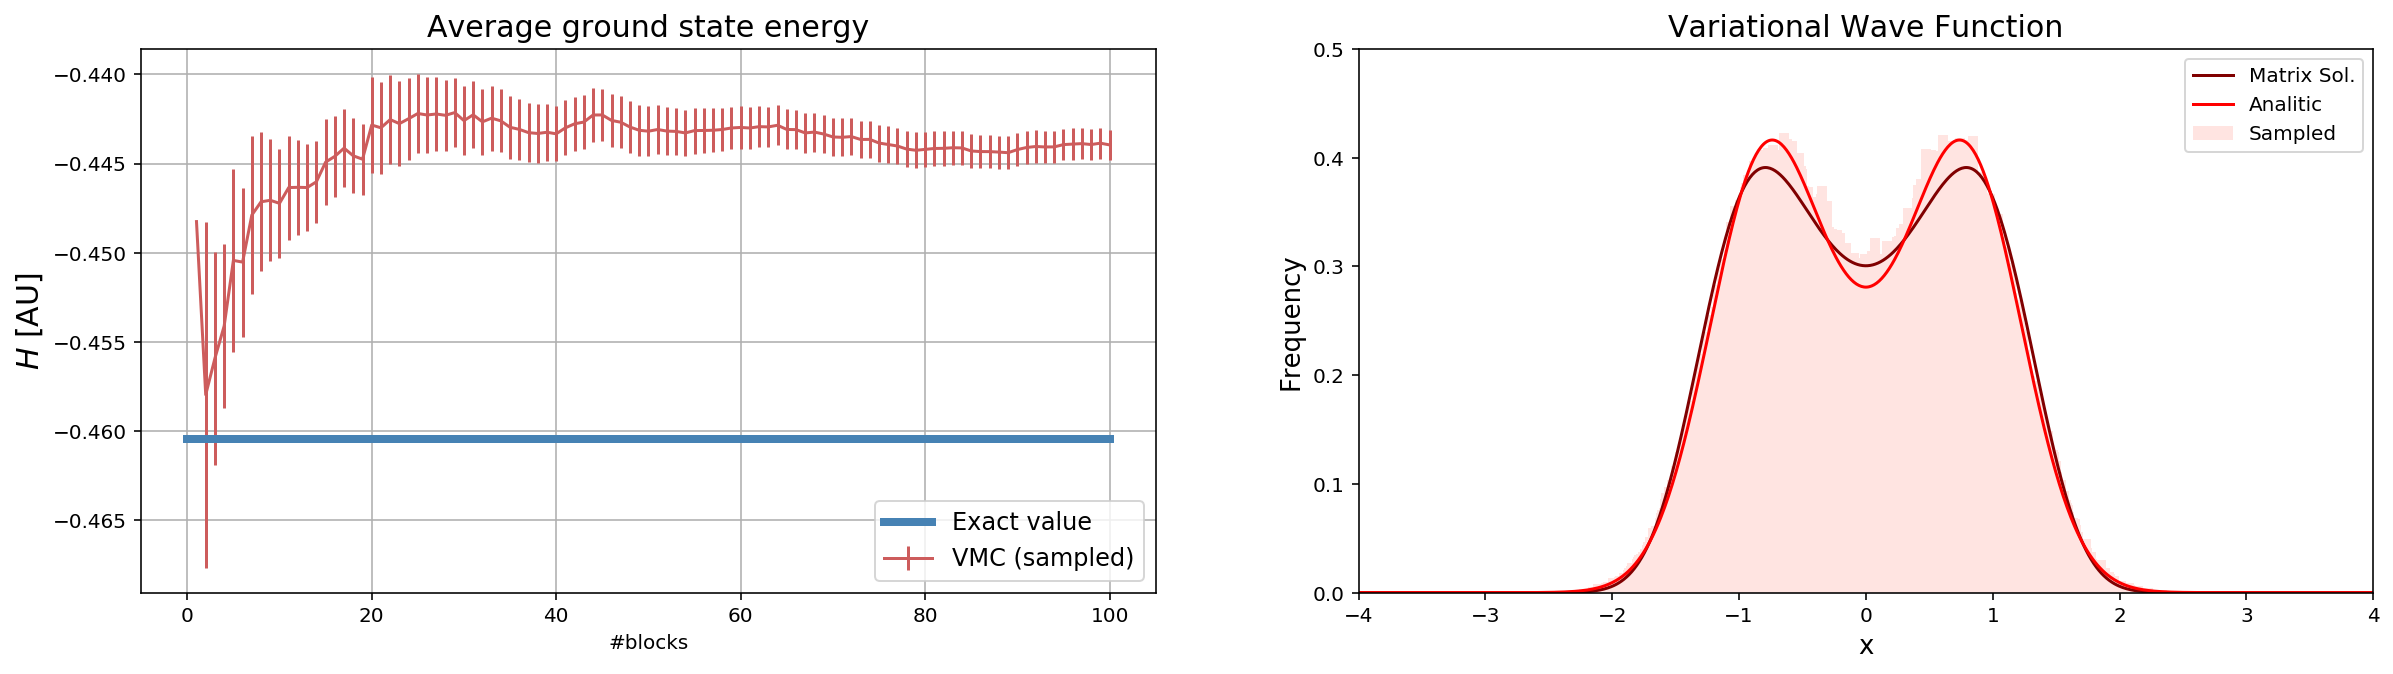

In [6]:
fig , axs = plt.subplots(1,2, figsize=(20,5))

axs[0].errorbar(block,Ham,xerr=None,yerr=err_H, color='indianred', label='VMC (sampled)')
axs[0].plot([0,100], [-0.46046587969271563,-0.46046587969271563], color='steelblue', label='Exact value',linewidth=4)
axs[0].set_title('Average ground state energy', fontsize=15)
axs[0].set_xlabel('#blocks')
axs[0].set_ylabel('$H$ [AU]', fontsize=15)
axs[0].grid()
axs[0].legend(loc=4,fontsize='large')


axs[1].plot(x,(psi[0])**2, color = 'maroon', label='Matrix Sol.')
axs[1].set_xlim((-4, 4))
axs[1].set_ylim((0, 0.5))
axs[1].plot(x, Psi_Sq(x, mu, sigma)/norm, color='red', label = 'Analitic')
axs[1].bar(r, isto, align='center', width=0.08, color='mistyrose',label="Sampled")
axs[1].legend()
axs[1].set_title('Variational Wave Function', fontsize=15)
axs[1].set_xlabel('x', fontsize=13)
axs[1].set_ylabel('Frequency', fontsize=13)

plt.show()

Per quanto riguarda il valor medio dell'energia, il risultato ottenuto con VMC si scosta dal valore analitico. Ritengo questo scostamento accettabile in quanto prima di partire con la risoluzione del problema sono state fatte delle ipotesi abbastanza stringenti, ovvero che la funzione d'onda fosse data dalla somma di due gaussiane. Inoltre, utilizzando un metodo variazionale è possibile che non si raggiunga il minimo globale della funzione. <br/> Per quanto riguarda l'istogramma, invece, i tre risultati sono in ottimo accordo reciproco, soprattutto nelle zone periferiche del dominio. In prossimità dei due picchi le curve sono leggeremente diverse ma si può comunque afferamre che la funzione d'onda è stata campionata correttamente.

## Esercizio 08.3

Use the PIMC/PIGS code we have provided to study the same 1D quantum system. Use the PIGS algorithm ($T=0$) to project
- a constant trial wave function, $\Psi_T(x)=1$
- using $\Psi_T(x) = \Psi_T^{\sigma,\mu}(x)$ with the variational parameters you have optimized.

<span style="color:red">Compare your results with those obtained with your VMC code</span>. By using $\Psi_T^{\sigma,\mu}(x)$, how much can you reduce the imaginary time propagation with respect to the first case?

<span style="color:red">Finally, use the PIMC algorithm ($T>0$) to observe how the histogram with the sampled configurations changes by increasing the temperature.</span>

Il codice fornito simula lo stesso sistema quantistico di prima, ma con due metodi alternativi. <br/>
Il metodo PIMC (*Path Integral Monte Carlo*) simula un sistema quantistico di N particelle interagenti paragonandolo ad un sistema classico di N polimeri interagenti ed è in funzione della temperatura $T$ a cui si simula il sistema, mentre il metodo PIGS (*Path Integral Ground State*) è un metodo esatto che lavora a temperatura nulla e sfrutta l'evoluzione temporale con tempi immaginari. È importante ricordare che per tempi immaginari grandi, lo stato quantistico rappresentato diventa proporzionale al ground state del sistema. <br/>
Prima di eseguire il codice, è stato necessario aggiungere la forma del potenziale di interazionee delle due funzioni d'onda da studiare.

### PIGS $(T=0)$

Ho rappresentato il sistema con diversi tempi di evoluzione immaginari: per $\tau=8$ ho rappresentato anche l'energia totale (sia per $\Psi=1$ che per $\Psi^{\mu,\sigma}$) sovrapponendola al calcolo fatto con le matrici. Successivamente, ho ridotto il tempo di propagazione (dal file `input.dat`) e ho rappresentato il campionamento della funzione d'onda in entrambi i casi. Si osserva che per tempi più piccoli, il campionamento con $\Psi=1$ si appiattisce e si allarga, allontanandosi dalla soluzione "esatta".

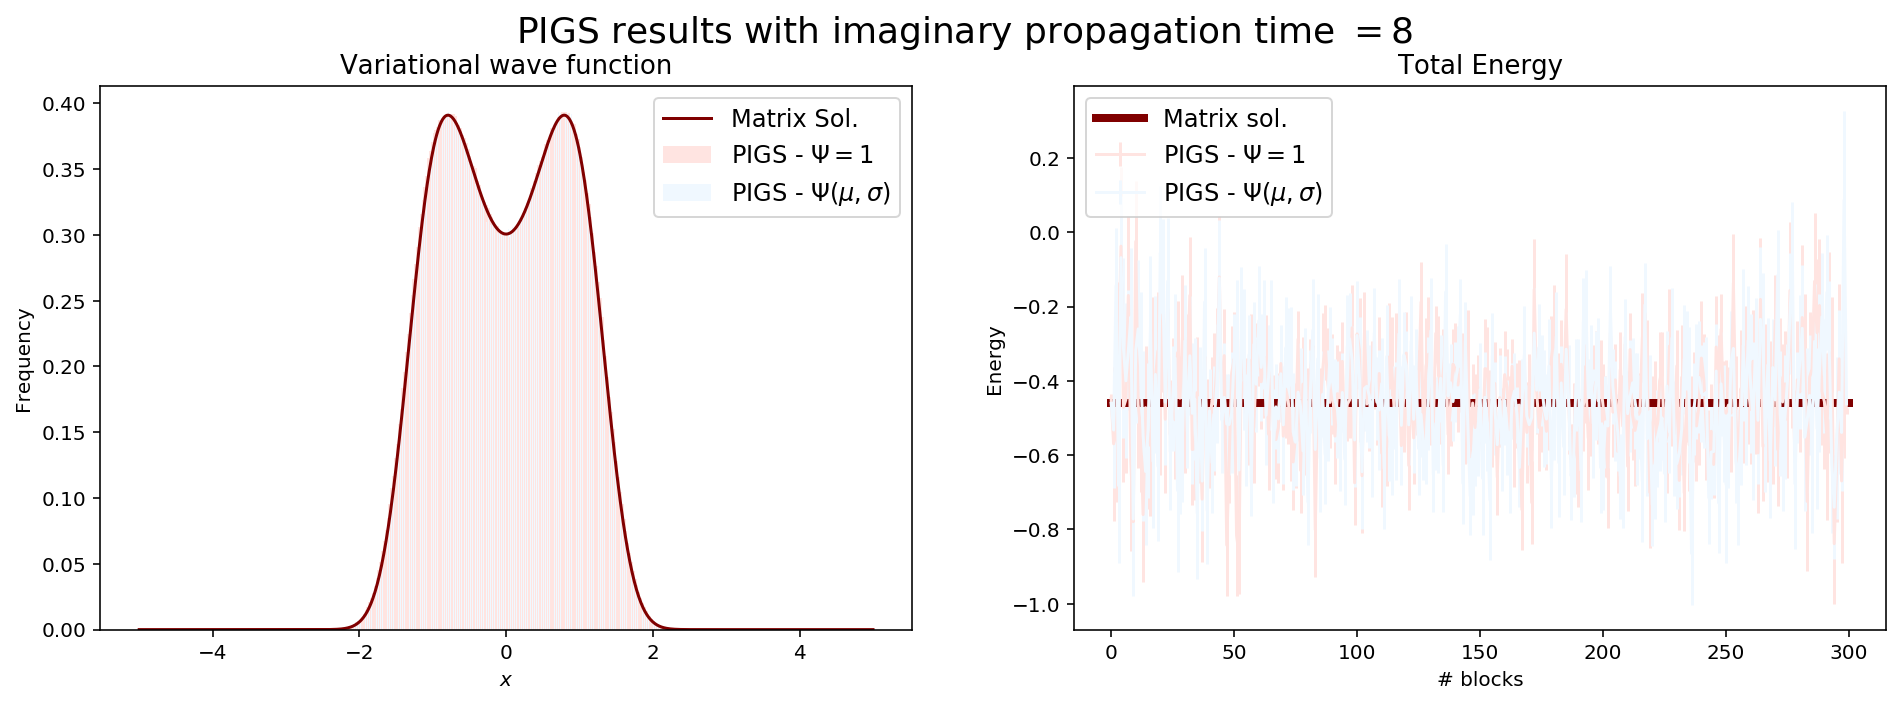

In [11]:
(r, psi_1_8) = np.loadtxt("QMC_1D/PIGS/PIGS8/psi1/probability.dat", usecols=(0,1), unpack=True)
psi_2_8 = np.loadtxt("QMC_1D/PIGS/PIGS8/psi2/probability.dat", usecols=1, unpack=True)

n, kin_1_8, errkin_1_8 = np.loadtxt("QMC_1D/PIGS/PIGS8/psi1/kinetic.dat", usecols=(0,1,2), unpack=True)
pot_1_8, errpot_1_8 = np.loadtxt("QMC_1D/PIGS/PIGS8/psi1/potential.dat", usecols=(1,2), unpack=True)
    
kin_2_8, errkin_2_8 = np.loadtxt("QMC_1D/PIGS/PIGS8/psi2/kinetic.dat", usecols=(1,2), unpack=True)
pot_2_8, errpot_2_8 = np.loadtxt("QMC_1D/PIGS/PIGS8/psi2/potential.dat", usecols=(1,2), unpack=True)

fig , axs = plt.subplots(1,2, figsize=(16,5))

plt.suptitle('PIGS results with imaginary propagation time $=8$', fontsize=18)

axs[0].set_title('Variational wave function', fontsize=13)
axs[0].bar(r, psi_1_8, align='center', width=0.08, color='mistyrose',label="PIGS - $\Psi=1$")
axs[0].plot(x,(psi[0])**2, color = 'maroon', label='Matrix Sol.')
axs[0].bar(r, psi_2_8, align='center', width=0.01, color='aliceblue', label="PIGS - $\Psi(\mu,\sigma)$")
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('Frequency')
axs[0].legend(fontsize='large')

axs[1].set_title('Total Energy', fontsize=13)
axs[1].errorbar([0, len(n)], [-0.46046587969271563, -0.46046587969271563], label = 'Matrix sol.', color='maroon', linewidth=4)
axs[1].errorbar(n, kin_1_8+pot_1_8, yerr=(errkin_1_8+errpot_1_8), color='mistyrose', label="PIGS - $\Psi=1$")
axs[1].errorbar(n, kin_2_8+pot_2_8, yerr=(errkin_2_8+errpot_2_8), color='aliceblue', label="PIGS - $\Psi(\mu,\sigma)$")
axs[1].set_xlabel("# blocks")
axs[1].set_ylabel("Energy")
axs[1].legend(fontsize='large')


plt.show()

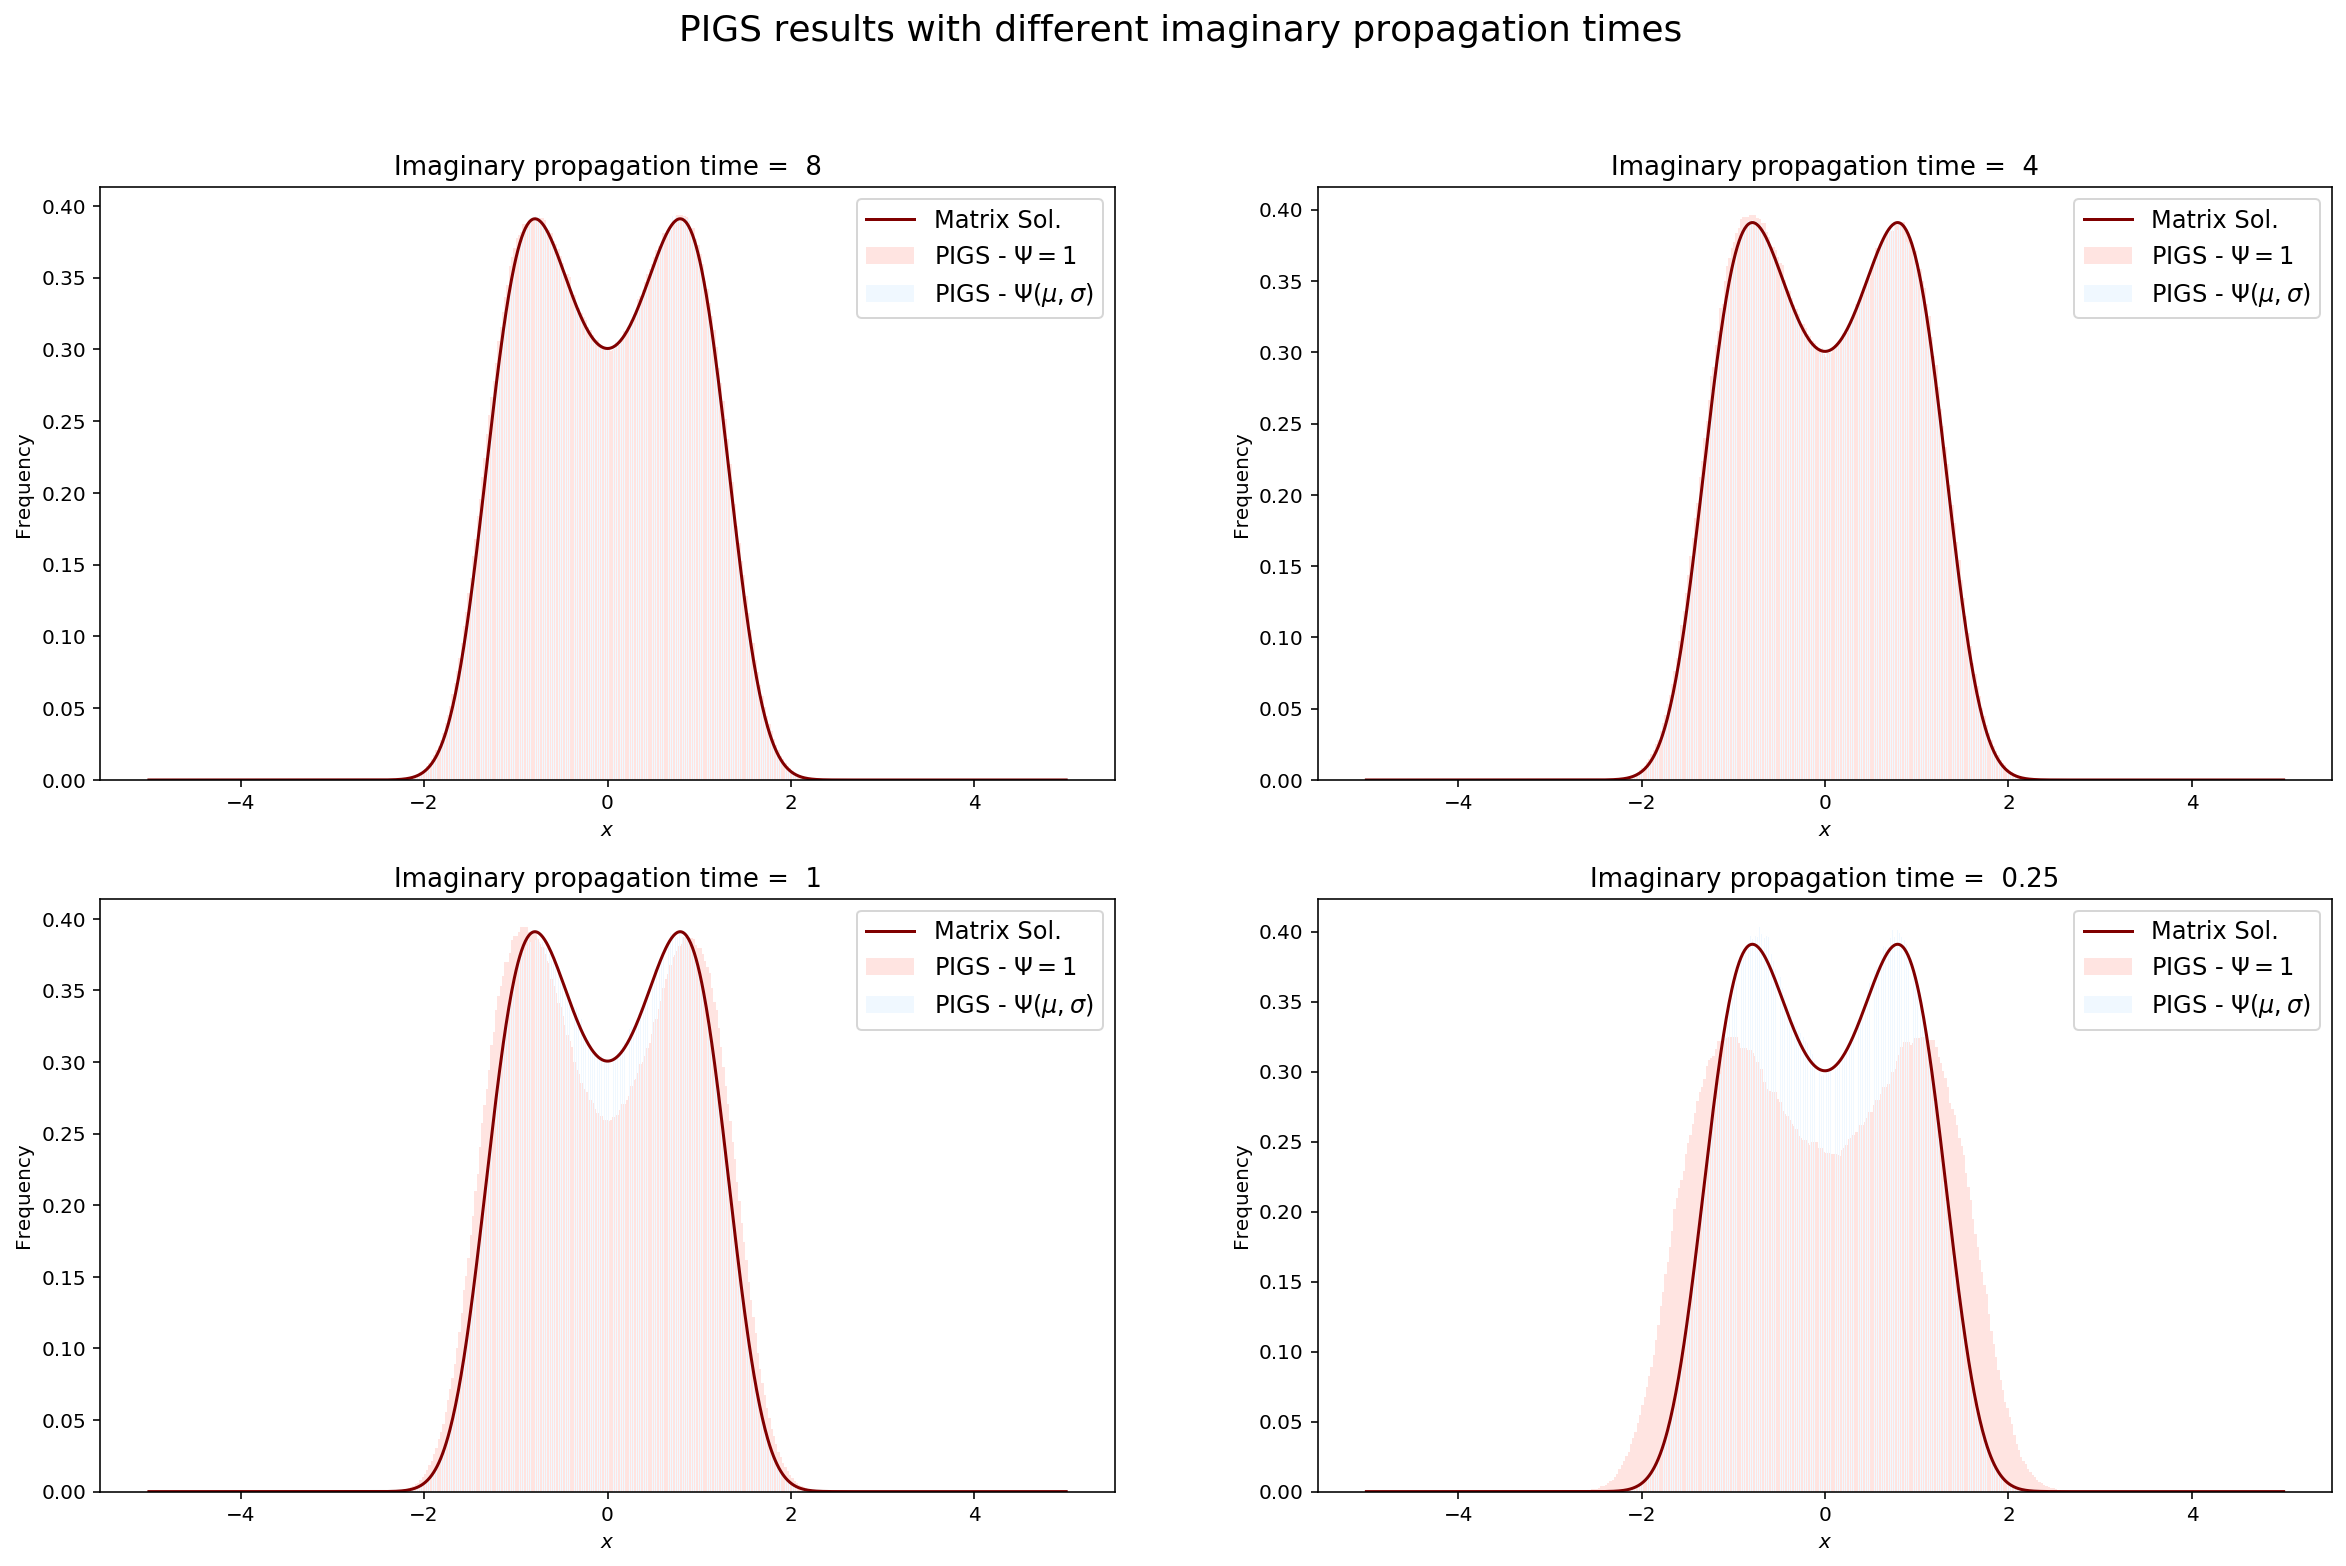

In [8]:
psi_1_4 = np.loadtxt("QMC_1D/PIGS/PIGS4/psi1/probability.dat", usecols=1, unpack=True)
psi_2_4 = np.loadtxt("QMC_1D/PIGS/PIGS4/psi2/probability.dat", usecols=1, unpack=True)

psi_1_1 = np.loadtxt("QMC_1D/PIGS/PIGS1/psi1/probability.dat", usecols=1, unpack=True)
psi_2_1 = np.loadtxt("QMC_1D/PIGS/PIGS1/psi2/probability.dat", usecols=1, unpack=True)

psi_1_025 = np.loadtxt("QMC_1D/PIGS/PIGS025/psi1/probability.dat", usecols=1, unpack=True)
psi_2_025 = np.loadtxt("QMC_1D/PIGS/PIGS025/psi2/probability.dat", usecols=1, unpack=True)



fig , axs = plt.subplots(2,2, figsize=(20,12))

plt.suptitle('PIGS results with different imaginary propagation times', fontsize=18)


axs[0,0].set_title('Imaginary propagation time =  8', fontsize=13)
axs[0,0].bar(r, psi_1_8, align='center', width=0.08, color='mistyrose',label="PIGS - $\Psi=1$")
axs[0,0].bar(r, psi_2_8, align='center', width=0.01, color='aliceblue', label="PIGS - $\Psi(\mu,\sigma)$")

axs[0,1].set_title('Imaginary propagation time =  4', fontsize=13)
axs[0,1].bar(r, psi_1_4, align='center', width=0.08, color='mistyrose',label="PIGS - $\Psi=1$")
axs[0,1].bar(r, psi_2_4, align='center', width=0.01, color='aliceblue', label="PIGS - $\Psi(\mu,\sigma)$")

axs[1,0].set_title('Imaginary propagation time =  1', fontsize=13)
axs[1,0].bar(r, psi_1_1, align='center', width=0.08, color='mistyrose',label="PIGS - $\Psi=1$")
axs[1,0].bar(r, psi_2_1, align='center', width=0.01, color='aliceblue', label="PIGS - $\Psi(\mu,\sigma)$")

axs[1,1].set_title('Imaginary propagation time =  0.25', fontsize=13)
axs[1,1].bar(r, psi_1_025, align='center', width=0.08, color='mistyrose',label="PIGS - $\Psi=1$")
axs[1,1].bar(r, psi_2_025, align='center', width=0.01, color='aliceblue', label="PIGS - $\Psi(\mu,\sigma)$")


for ax in axs.flat:
    ax.set_xlabel('$x$')
    ax.set_ylabel('Frequency')
    ax.plot(x,(psi[0])**2, color = 'maroon', label='Matrix Sol.')
    ax.legend(fontsize='large')
    
plt.show()


### PIMC $(T>0)$

Eseguendo il codice PIMC ho lavorato solo sulla funzione d'onda "a doppia gaussiana" e ho focalizzato la mia attenzione sulle diverse forme della funzione d'onda in funzione della temperatura. Per T=1.25 (come al solito in unità naturali) ho rappresentato la funzione d'onda campionata e l'energia totale del sistema. In entrambi i grafici si nota come avere una temperatura diversa da zero peggiora la qualità delle stime: la funzione d'onda non si sovrappone in modo precisdo a quella ottenuta con metodi numerici, e l'energia di ground state è leggermente più alta rispetto a quella ottenuta con PIGS. <br/>
Questo è dovuto al fatto che aumentando la temperatura, si vanno a popolare per eccitazione terminca alucni stati eccitati che prima erano inaccessibili al sistema. Quindi la funzione d'onda di ground state si appiattisce e si allarga, mentre l'energia del sistema è complessivamente più alta rispetto al caso $T=0$.
Da ultimo, ho rappresentato la funzione d'onda per diversi valori di temperatura confermando questa ipotesi. Si nota in particolare che per temperature molto alte (T=80) si perde completamente il comportamento oscillante della funzione d'onda (dato dalla parte "a sombrero" di $V(x)$) e ci si avvicina ad un problema di una particella posta in una buca infinita.

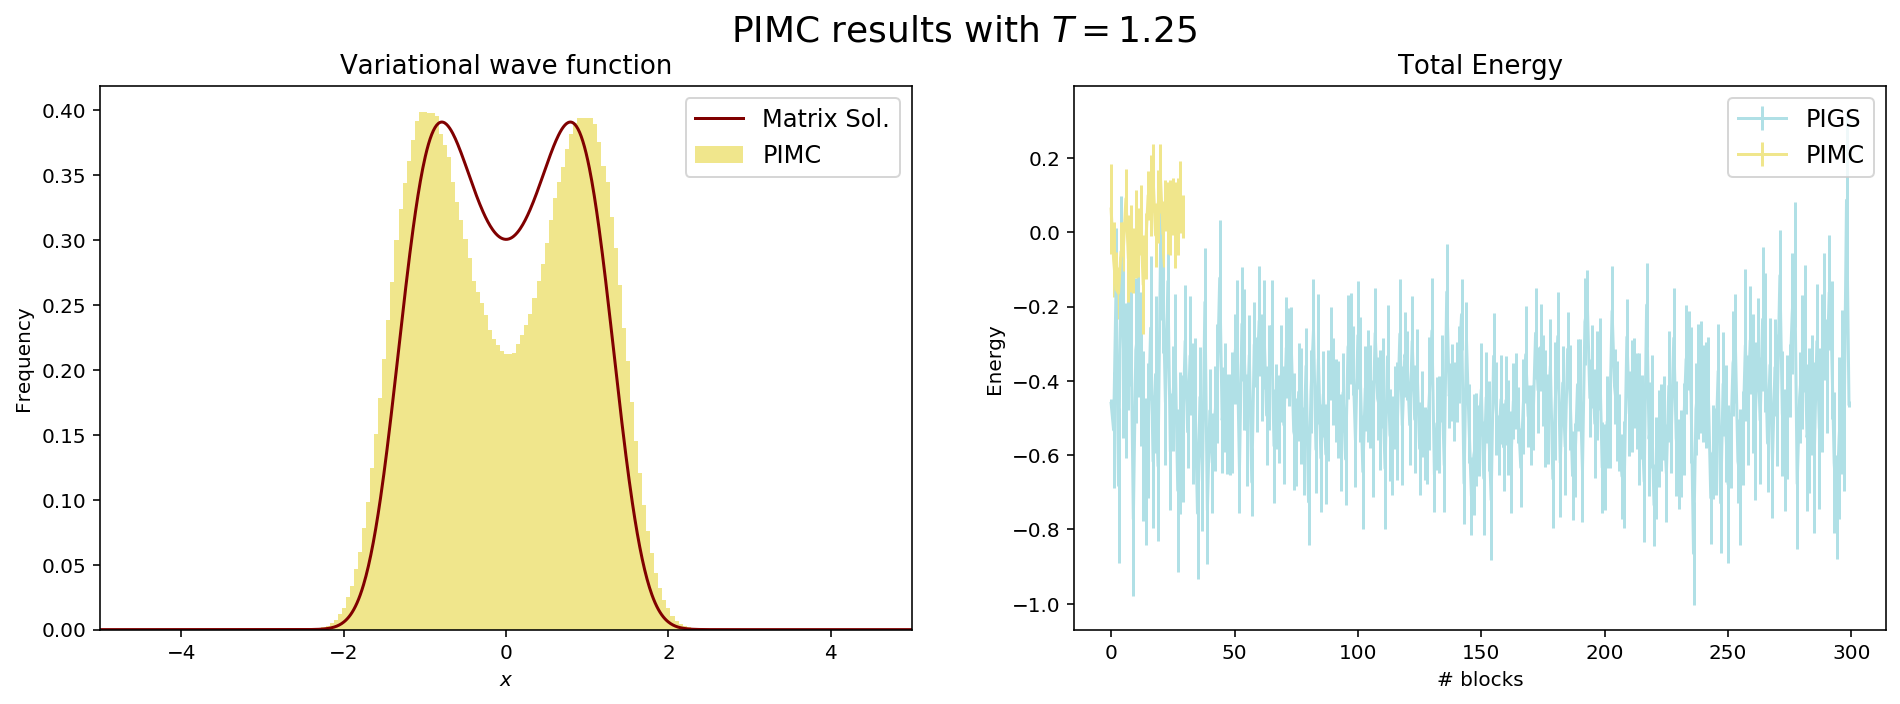

In [9]:
(r, psi_125, err125) = np.loadtxt("QMC_1D/PIMC/PIMC125/probability.dat", usecols=(0,1,2), unpack=True)


nn, kin_125, errkin_125 = np.loadtxt("QMC_1D/PIMC/PIMC125/kinetic.dat", usecols=(0,1,2), unpack=True)
pot_125, errpot_125 = np.loadtxt("QMC_1D/PIMC/PIMC125/potential.dat", usecols=(1,2), unpack=True)
    

fig , axs = plt.subplots(1,2, figsize=(16,5))

plt.suptitle('PIMC results with $T=1.25$', fontsize=18)

axs[0].set_title('Variational wave function', fontsize=13)
axs[0].plot(x,(psi[0])**2, color = 'maroon', label='Matrix Sol.')
axs[0].bar(r, psi_125, align='center', width=0.1, color='khaki', label="PIMC")
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(-5,5)
axs[0].legend(fontsize='large')

axs[1].set_title('Total Energy', fontsize=13)
axs[1].errorbar(n, kin_2_8+pot_2_8, yerr=(errkin_2_8+errpot_2_8), color='powderblue', label="PIGS")
axs[1].errorbar(nn, kin_125+pot_125, yerr=(errkin_125+errpot_125), color='khaki', label="PIMC")
axs[1].set_xlabel("# blocks")
axs[1].set_ylabel("Energy")
axs[1].legend(fontsize='large')


plt.show()

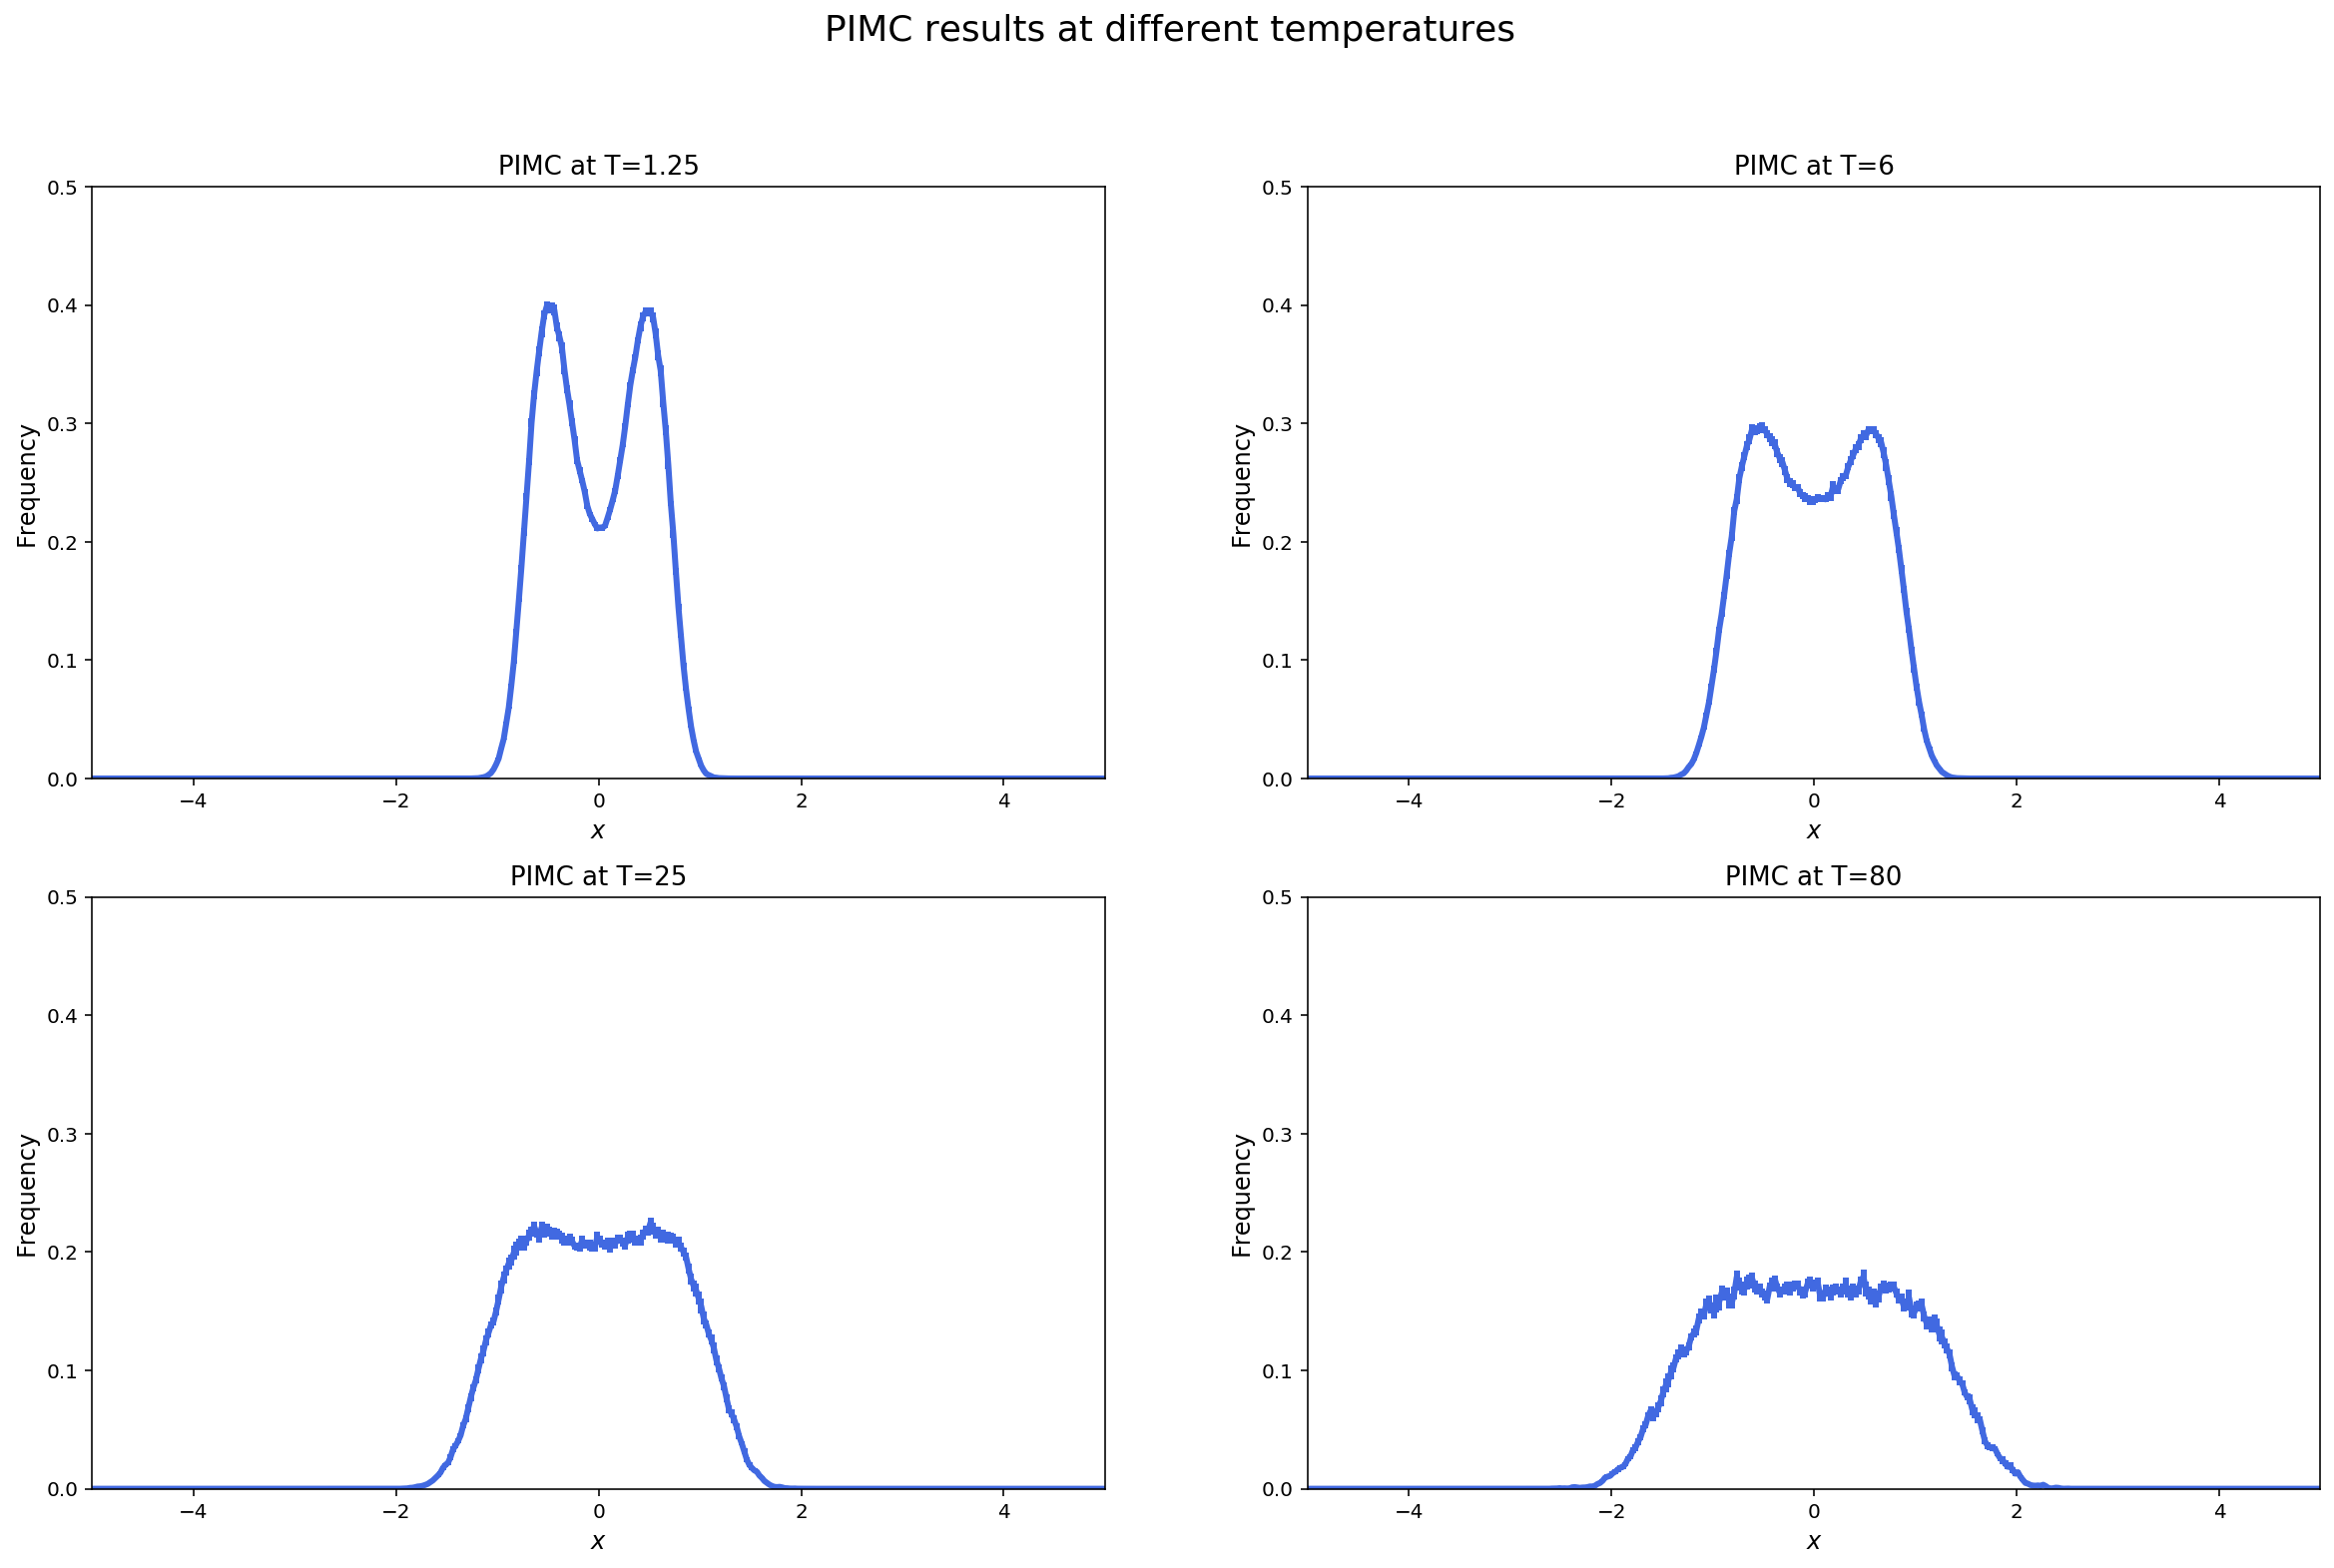

In [12]:
psi_6, err6 = np.loadtxt("QMC_1D/PIMC/PIMC6/probability.dat", usecols=(1,2), unpack=True)
psi_25, err25 = np.loadtxt("QMC_1D/PIMC/PIMC25/probability.dat", usecols=(1,2), unpack=True)
psi_80, err80 = np.loadtxt("QMC_1D/PIMC/PIMC80/probability.dat", usecols=(1,2), unpack=True)


fig , axs = plt.subplots(2,2, figsize=(20,12))

plt.suptitle('PIMC results at different temperatures', fontsize=18)

axs[0,0].errorbar(r,psi_125, err125, label='PIMC at T=1.25', c='royalblue', linewidth=3)
axs[0,0].set_title('PIMC at T=1.25', fontsize=13)
axs[0,1].errorbar(r,psi_6, err6, label='PIMC at T=6', c='royalblue', linewidth=3)
axs[0,1].set_title('PIMC at T=6', fontsize=13)
axs[1,0].errorbar(r,psi_25, err25, label='PIMC at T=25', c='royalblue', linewidth=3)
axs[1,0].set_title('PIMC at T=25', fontsize=13)
axs[1,1].errorbar(r,psi_80, err80, label='PIMC at T=80', c='royalblue', linewidth=3)
axs[1,1].set_title('PIMC at T=80', fontsize=13)

for ax in axs.flat:
    ax.set_xlabel('$x$', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_ylim(0, 0.5)
    ax.set_xlim(-5,5)

plt.show()